In [1]:
## imports
import pandas as pd
import numpy as np
import re
import requests
import yaml
import tweepy
import pickle
import plotnine
from plotnine import *
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

## repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_colwidth', None)

## function to load credentials yaml
def load_creds(path: str):
    with open(path, 'r') as stream:
        try:
            creds = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    return(creds)

# 0. Setup: authenticate to Twitter API

In [2]:
## read creds file- replace with path to your creds
creds = load_creds("../../../private_data/my_cred_jlauer.yaml")


In [3]:
## use bearer token to initialize a tweepy client (connection with twitter API)
client = tweepy.Client(bearer_token= creds['twitter_api']['bearer_token'])

## print type
print(type(client))

<class 'tweepy.client.Client'>


# 1. Use one: pulling recent tweets associated with a hashtag

Here, we're going to pull recent tweets associated with the metoo hashtag. Note that if we want tweets older than a week, we need to either get an academic license (rather than a student one) or use another method (discussion here: https://stackoverflow.com/questions/24214189/how-can-i-get-tweets-older-than-a-week-using-tweepy-or-other-python-libraries) 

The `Cursor` class w/in tweepy allows us to pull while skipping annoying things like pagination

**Example use**: Gallagher et al. look at the use of hashtags #BlackLivesMatter, #AllLivesMatters, and others in days following instances of officer-involved shootings or indictments/non-indictments. They examine things like the different words that are used in tweets containing those hashtags and whether the conversations occur separately or whether those using the #AllLivesMatter hashtag are inserting themselves into BLM conversations: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0195644

## 1.1 Printing tweets and their attributes

In [4]:
## construct a hashtag
## we're filtering out retweets for simplicity
## discussion here of query construction:
## https://developer.twitter.com/en/docs/twitter-api/tweets/search/integrate/build-a-query
query = "#metoo -is:retweet is:verified"

tweets_mt = client.search_recent_tweets(query = query, max_results = 100,
                                    tweet_fields = ['created_at',
                                                    'author_id',
                                                   'geo',
                                                   'lang', 
                                                   'public_metrics'],
                                    user_fields = ['description',
                                                  'location',
                                                  'verified',
                                                  'public_metrics'],
                                    expansions = 'author_id',
                                    end_time = "2022-02-15T01:00:00-00:00")


In [5]:
## attributes of the tweet
### iterating over the list of tweets
### and for each tweet, pulling some info (just printing first 5)
tweet_res = [print("""On {}, {} tweeted {} in {} language, which was liked by {}
    """.format(tweet.created_at,
              tweet.author_id,
              tweet.text,
              tweet.lang,
              tweet.public_metrics['like_count']))
for tweet in tweets_mt.data[0:5]]



On 2022-02-15 00:50:05+00:00, 798547004477599744 tweeted This is huge. Ensuring that survivors get their day in court is one step closer to achieving both closure &amp; accountability. #MeToo https://t.co/tZVMOfoUEH in en language, which was liked by 9
    
On 2022-02-14 23:39:23+00:00, 432147992 tweeted on wednesday, our investigations team published a thoughtful look at what restorative justice could look like amid the #metoo movement.

@codycorrall + @Walldo did a fantastic job shepherding this one from start to finish: https://t.co/72F6BmOF0m in en language, which was liked by 1
    
On 2022-02-14 22:04:01+00:00, 410249471 tweeted Today workers are delivering petitions w/ 13,000 signatures calling on @topgolf to respect their workers! #stopgolf #onefairwage #metoo #timesup https://t.co/pEi63AyCIC in en language, which was liked by 1
    
On 2022-02-14 21:37:05+00:00, 29903031 tweeted From covid to #MeToo, the labor beat is resurgent. 

🎧Join @NiemanReports for a @TwitterSpaces Wed.

## 1.2 Printing attributes of users 

In [6]:
## add attributes of the user
users = {user["id"]: user for user in tweets_mt.includes['users']}

### similarly, iterating over the list of tweets
### and for each tweet, finding its author id and 
### printing some info
for tweet in tweets_mt.data[0:5]:
    u_info = users[tweet.author_id]
    print("""On {}, {}, whose verification status is: {}
    and follower count is: {}
    tweeted: {}
    """.format(tweet.created_at,
              u_info.username,
              u_info.verified,
            u_info.public_metrics['followers_count'],
            tweet.text))

On 2022-02-15 00:50:05+00:00, LindseyBoylan, whose verification status is: True
    and follower count is: 63345
    tweeted: This is huge. Ensuring that survivors get their day in court is one step closer to achieving both closure &amp; accountability. #MeToo https://t.co/tZVMOfoUEH
    
On 2022-02-14 23:39:23+00:00, samanthajtom, whose verification status is: True
    and follower count is: 3267
    tweeted: on wednesday, our investigations team published a thoughtful look at what restorative justice could look like amid the #metoo movement.

@codycorrall + @Walldo did a fantastic job shepherding this one from start to finish: https://t.co/72F6BmOF0m
    
On 2022-02-14 22:04:01+00:00, UltraViolet, whose verification status is: True
    and follower count is: 35002
    tweeted: Today workers are delivering petitions w/ 13,000 signatures calling on @topgolf to respect their workers! #stopgolf #onefairwage #metoo #timesup https://t.co/pEi63AyCIC
    
On 2022-02-14 21:37:05+00:00, Adrian

## 1.3 Storing that tweet and user information in a dataframe

If we want to work with this as data, instead of iterating and printing, 
want to store in a dataframe

### 1.3.1 Pull attributes/metadata about tweets

In [7]:

### define the attributes (need to be pulled
### in the search_recent_tweets call above)
tweet_attr = ['id',
              'created_at', 'author_id', 
             'text', 'lang', 'geo', 'public_metrics']

### function to iterate over attributes
def pull_attr(one_tweet, which_attr):
    all_attr = [one_tweet[attr] if attr != 'public_metrics'
                else 
                one_tweet[attr]['like_count']
                for attr in which_attr]
    return(all_attr)

### iterate over tweets and pull tweet info
tweets_info_list = [pull_attr(one_tweet, tweet_attr)
              for one_tweet in tweets_mt.data]

### transform into a dataframe
tweets_info_df = pd.DataFrame(tweets_info_list,
                                columns = tweet_attr)

tweets_info_df[tweets_info_df.lang == "en"].sort_values(by = 'public_metrics', 
                           ascending = False).head()


,id,created_at,author_id,text,lang,geo,public_metrics
64,1492868260852817933,2022-02-13 14:28:24+00:00,2835451658,"South Korea: The wife of a top presidential candidate has caused controversy after saying she’d jail journalists &amp; suggested #MeToo women are doing it for the money. Despite the comments in a fiery interview, her husband’s polling has actually increased.https://t.co/Ex6hRD1peL",en,None,901
47,1492999715159433220,2022-02-13 23:10:45+00:00,453704729,I’m sending love to @sistadbarnes today and wondering: \n\nWhy are we still platforming unrepentant abusers? Does #MeToo matter? \n\nAnd if #BlackLivesMatter why did artists in the #SuperBowl HalfTimeShow take a knee with @Kaepernick7 only to rock the mic for an unrepentant NFL? https://t.co/oNvF5iJSk6,en,None,256
54,1492931648177983489,2022-02-13 18:40:16+00:00,258135801,"If Ghomeshi/#MeToo taught me anything, it's that you must immediately harness people's outrage or you miss an opportunity. \n\nNow is not the time to focus on why it took so long for people to see the light. Now is the time to turn their outrage into action.",en,None,149
3,1493338530709487621,2022-02-14 21:37:05+00:00,29903031,"From covid to #MeToo, the labor beat is resurgent. \n\n🎧Join @NiemanReports for a @TwitterSpaces Wed. at 1p ET on how labor stories are becoming many of the nation’s biggest news stories w/ @LaurenKGurley, @greenhousenyt, @bigblackjacobin &amp; @hamiltonnolan: \nhttps://t.co/UBBc2NTo3B",en,None,137
15,1493283922008018946,2022-02-14 18:00:05+00:00,4898091,"The #MeToo movement in France could play into the battle to unseat Emmanuel Macron in April's presidential election. \n\nThe French president was elected with strong support from women, but that support has faltered 👇 https://t.co/gOzlBoGbnA https://t.co/Pt22ZF1eLx",en,None,98


### 1.3.2 Pull attributes/metadata about users

In [8]:
### define the user attributes (similarly need to be pulled)
user_attr = ['username', 'description',
             'location', 'verified', 'public_metrics']

### function to iterate over user attributes
def pull_user_attr(one_tweet, which_attr):
    
    one_user = users[one_tweet.author_id]
    all_attr = [one_tweet.author_id] + \
                [one_user[attr] 
                if 
                attr != "public_metrics"
                else 
                one_user[attr]['followers_count']
                for attr in which_attr] 
    return(all_attr)

### iterate over tweets and pull user info
users_info_list = [pull_user_attr(one_tweet, user_attr)
                    for one_tweet 
                    in tweets_mt.data]
user_info_df = pd.DataFrame(users_info_list,
                               columns = ['author_id'] + user_attr)

In [9]:
## merge on author id so that we have
## metadata on both tweets and users
tweets_df = pd.merge(tweets_info_df,
                          user_info_df,
                          on = 'author_id',
                          how = 'left',
                          suffixes = ['_tweet', '_user']).drop_duplicates(subset = 'id')

tweets_df.loc[tweets_df.lang == "en",
             ['text', 'public_metrics_tweet',
             'username', 'description', 
             'public_metrics_user']].sort_values(by = 'public_metrics_tweet', 
                            ascending = False).head()

,text,public_metrics_tweet,username,description,public_metrics_user
121,"South Korea: The wife of a top presidential candidate has caused controversy after saying she’d jail journalists &amp; suggested #MeToo women are doing it for the money. Despite the comments in a fiery interview, her husband’s polling has actually increased.https://t.co/Ex6hRD1peL",901,MrAndyNgo,"Independent journalist & author of NYT bestseller, 'Unmasked.' Editor-at-large: @TPostMillennial. Contact, support, follow: https://t.co/6ZvZk6Gwgx",976337
84,I’m sending love to @sistadbarnes today and wondering: \n\nWhy are we still platforming unrepentant abusers? Does #MeToo matter? \n\nAnd if #BlackLivesMatter why did artists in the #SuperBowl HalfTimeShow take a knee with @Kaepernick7 only to rock the mic for an unrepentant NFL? https://t.co/oNvF5iJSk6,256,deardrewdixon,Silence Breaker. Producer. Writer. Mom. She/Her/Hers. As seen in @OnTheRecordDoc Press Requests: ryanmaziepr@gmail.com,16863
105,"If Ghomeshi/#MeToo taught me anything, it's that you must immediately harness people's outrage or you miss an opportunity. \n\nNow is not the time to focus on why it took so long for people to see the light. Now is the time to turn their outrage into action.",149,JulieSLalonde,6x award-winning feminist buzzkill. Franco-ontarienne. 🏳️‍🌈 Femme. 💛MMA & VWs. Je suis confiante avec bonne raison. I believe in high heels & high standards.,38665
3,"From covid to #MeToo, the labor beat is resurgent. \n\n🎧Join @NiemanReports for a @TwitterSpaces Wed. at 1p ET on how labor stories are becoming many of the nation’s biggest news stories w/ @LaurenKGurley, @greenhousenyt, @bigblackjacobin &amp; @hamiltonnolan: \nhttps://t.co/UBBc2NTo3B",137,Adriana_Lacy,editor @niemanfdn @harvard • freelance audience/product strategist • running @jourmentors • was @axios @latimes @nytimes • hello@adrianalacy.com,14412
24,"The #MeToo movement in France could play into the battle to unseat Emmanuel Macron in April's presidential election. \n\nThe French president was elected with strong support from women, but that support has faltered 👇 https://t.co/gOzlBoGbnA https://t.co/Pt22ZF1eLx",98,FinancialTimes,"The best of FT journalism, including breaking news and analysis. Follow @ftopinion @ftweekend and @ftworldnews for more from the Financial Times",7124282


## 1.4 Exploring the results

In [10]:
### 1. what percent are diff languages?
tweets_df.lang.value_counts(normalize = True)

en     0.57
fr     0.10
es     0.10
nl     0.08
pt     0.04
und    0.03
da     0.02
el     0.02
ja     0.02
de     0.01
it     0.01
Name: lang, dtype: float64

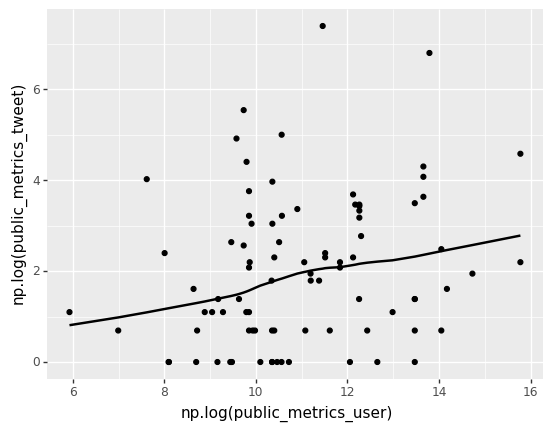

<ggplot: (8772779066853)>

In [11]:
### 2. what's the relationship b/t followers and likes? (logged and removing 0)
(ggplot(tweets_df[(tweets_df.public_metrics_user > 0) &
                  (tweets_df.public_metrics_tweet > 0)], 
                  aes(x = 'np.log(public_metrics_user)', 
                    y = 'np.log(public_metrics_tweet)')) +
geom_point() +
geom_smooth(method = "lowess", se = False))


In [12]:
### 3. search for who's tagged in a tweet - restricting to english language
tag_pat = r".*(@\w+).*"
### iterate over tweets
all_tags = [re.findall(tag_pat, one_tweet) 
            for one_tweet in tweets_df.text[tweets_df.lang == "en"]
           if len(re.findall(tag_pat, one_tweet)) > 0]
### flatten list to count repeats and summarize top
all_tags_onelist = [item for sublist in all_tags for item in sublist]
pd.Series(all_tags_onelist).value_counts()



@katierosman        1
@FreeXueBing        1
@alainaxhampton     1
@hamiltonnolan      1
@daphnehk           1
@sistadbarnes       1
@JonEvansWECT       1
@reneeknake         1
@Kaepernick7        1
@injusticewatch     1
@bbgequality        1
@topgolf            1
@Walldo             1
@vikramsampath      1
@SabaKarim          1
@OnTheRecordDoc     1
@FT                 1
@demorgen           1
@RAINN              1
@BuzzFeedNews       1
@ReliableSources    1
dtype: int64

In [13]:
### 4. search for hashtags in a tweet
hash_pat = r".*(\#\w+)\s+.*"
### iterate over tweets
all_hasht = [re.findall(hash_pat, one_tweet) 
            for one_tweet in tweets_df.text
           if len(re.findall(hash_pat, one_tweet)) > 0]

### flatten list to count repeats and summarize top
all_hash_onelist = [item for sublist in all_hasht for item in sublist]
pd.Series(all_hash_onelist).value_counts()

#MeToo                      50
#metoo                      13
#Metoo                       9
#EmPauta                     4
#MeTooAcademia               2
#DontLookUp                  2
#terreurachterdevoordeur     1
#tweezomers                  1
#石川優実                        1
#metooGR                     1
#SuperBowl                   1
#Λιγναδης                    1
#auspol                      1
#ジェンダー平等                     1
#SaintValentin               1
#notmyhost                   1
#buitenhof                   1
#Daech                       1
#BlackLivesMatter            1
#MeTooUCLouvain              1
#covidlong                   1
#ValentinesDay2022           1
#timesup                     1
#heforshe                    1
#BEIJING2022                 1
dtype: int64

In [14]:
SAVE_BACKUP = False
if SAVE_BACKUP:
    tweets_df.to_pickle("../../../private_data/tweets_w22.pkl")

# 2. Use two: examining relationships between those on the site

- Previous example showed both who tweeted with a lot of likes/high follower counts, and also who they tended to tag in the tweets
- We can also use twitter to form the start of a social network where nodes are different accounts and edges are drawn between followers who follow the same focal account; here, we'll look at a simplified form

**Example use**: Mosleh et al. do a field experiment where they create Twitter bots that either self-identify as Republican or Democrat and then the bots follow people. They look at how the partisanship of the user the bot follows predicts whether the user follows a bot back: https://www.pnas.org/content/118/7/e2022761118.short

In [15]:
## choose a focal account from above
READ_SAVED = True
if READ_SAVED:
    tweets_df = pd.read_pickle("../../../public_data/tweets_w22.pkl")


focal_acc_row = tweets_df[tweets_df.username.str.contains("AndyNgo")]
focal_acc_id = focal_acc_row.author_id.iloc[0]

## can also get their id based on username
focal_acc_id_alt = client.get_user(username = "MrAndyNgo").data['id']

assert focal_acc_id == focal_acc_id_alt

In [16]:
## pull user followers (defaults to most recent 100 followers)
follow_focal = client.get_users_followers(id = focal_acc_id,
                                         user_fields = user_attr)

## get data - this time more manually rather than function
user_data = pd.DataFrame({'uname': [user['username'] for user in follow_focal.data],
                          'description': [user['description'] for user in follow_focal.data],
                          'user_id': [user['id'] for user in follow_focal.data],
                         'followers': [user['public_metrics']['followers_count'] 
                                        for user in follow_focal.data]})
user_data.sort_values(by = 'followers', ascending = False)

## can then see who are followers of followers
follow_top_row = user_data[user_data.followers == np.max(user_data.followers)]
follow_top_id = follow_top_row.user_id.iloc[0]

## similarly, get followers and view them (would probably want to write function at this point)
follow_degree2 = client.get_users_followers(id = follow_top_id,
                                         user_fields = user_attr)
user_data_degree2 = pd.DataFrame({'uname': [user['username'] for user in follow_degree2.data],
                          'description': [user['description'] for user in follow_degree2.data],
                          'user_id': [user['id'] for user in follow_degree2.data],
                         'followers': [user['public_metrics']['followers_count'] for user in follow_degree2.data]})
user_data_degree2.sort_values(by = 'followers', ascending = False)

,uname,description,user_id,followers
27,thetoyman1,"Media Consultant, Lakers Fan, Vegas Expert/Dodger Fan/Radio/TV Producer/ News Junky/ Creator of Products/Proud Military Supporter/support Israel/ 🇺🇸",1091216816,64264
52,rob41278,@NJNATIONALGUARD '09-17 #scoutsout\n@usarmyreserve. 2020\n@yankees @giants\n@ninelineapparel ambassador. Use rob1978 at checkout for discounts! 🇺🇸,36196022,2448
96,gruummpygrandpa,,1407716095088226311,2351
98,Robcat99_,Streamer 𓀡 | @Twitch affiliate & @Amazon Associate |,3560881103,1606
70,w00dbea,twitter is a Charlie Foxtrot lol,1628317284,1342
...,...,...,...,...
42,Missa_Stan,,1445100683951161345,0
48,Brownwaterdog,,1462207639593521154,0
56,ntbennett2021,,1466097160303304707,0
58,JohnnyU86977514,,1494146564025196544,0


,uname,description,user_id,followers
74,Hotel3_,307th Meme Division. Bring back asylums! \n#MAGA #KAG #HOG #HANGOVERGANG #Constitutionalist,1226541413883695104,8498
1,Woodman775,#CONSTITUTION #MAGA #2A #Conservative #Patriot #Veteran,823616163624222720,7376
90,timurtu,Streamer / creator / developer https://t.co/41eQXL2Cy4,353465638,4509
17,Sandrawinfrey91,"I am a TRUMPER.♥️🇺🇸#Trump 2020🇺🇸😀#MAGA,#Conservative.♥️#PATRIOT #KAG2020 American First🇺🇸 🙏 PLEASE NO PRIVATE MASSAGES.✌🇺🇸.IFB Trump people.🇺🇸🙂",957795061231771649,4048
6,JosPauloMarcol1,"Coronel Veterano da PMESP, Advogado e Jornalista. Palmeirense e Bolsonarista sim senhor! Se me seguir retribuo na hora.",1318150167481274368,3895
...,...,...,...,...
67,elephantcollect,Retired,46032824,16
66,Margaret260302,True Love ❤️😍 is all I want🥰can you give me,1493618310126125058,10
80,MiaKim76833868,am living the best of life peaceful,1492262781856452608,4
26,quayeanas,Okay am here to look job to do or any work awww my son Love's birthday,1494153766416883715,4


# Use three: extract recent tweets from a specific user

If we have a dataset or panel of users, can get their tweets and extract properties like likes, retweets, etc (most recent ~3200)

**Example use**: Bisbee et al. construct a panel of political science professors use Twitter; they then follow those users and looks at who retweets each other's research, finding that male professors are more likely to pass on research by other male professors than by female professors - https://www.cambridge.org/core/journals/perspectives-on-politics/article/polisci-twitter-a-descriptive-analysis-of-how-political-scientists-use-twitter-in-2019/C8A193C3E939C1ABCD4600DFE8AEF79A

In [17]:
## step 1: choose a focal account and get their numeric id
focal_account = "SenatorHassan"
get_id = client.get_user(username= focal_account, user_fields = user_attr)
hassan_id = get_id.data['id']

## step 2: use the get_users_tweets method to 
## pull recent tweets - here, i'm pulling most recent 100
hassan_tweets_resp = client.get_users_tweets(id = hassan_id,
                                       max_results = 100, 
                                       tweet_fields = tweet_attr)

## step 3: that returns a response with data as an attribute
## to turn into a dataframe, use function above 
hassan_tweets_list = [pull_attr(one_tweet, tweet_attr)
                      for one_tweet in hassan_tweets_resp.data]

### step 4: transform into a dataframe
senator_tweets_df = pd.DataFrame(hassan_tweets_list,
                                columns = tweet_attr)
senator_tweets_df.head()

,id,created_at,author_id,text,lang,geo,public_metrics
0,1494082137934467084,2022-02-16 22:51:55+00:00,946549322,Check out this modern-day message in a bottle from fifth &amp; sixth graders at Rye Junior High School. It’s amazing to see the work of NH students &amp; teachers in bringing science alive!\n\nhttps://t.co/JbtTeKdQxM,en,None,23
1,1494039448446808068,2022-02-16 20:02:17+00:00,946549322,Let's not sugar coat it.\n\nClimate change is causing sea levels to rise - and it will likely get worse. That's why I led efforts to secure robust funding in the bipartisan infrastructure law for coastal resilience projects to help protect NH communities.\n\nhttps://t.co/Yw7One2maa,en,None,78
2,1494020423306129418,2022-02-16 18:46:41+00:00,946549322,Some insurers are illegally denying women coverage for birth control &amp; forcing them to pay out-of-pocket for contraception. I am calling on the administration to stand up to insurance companies that are violating the law and withholding reproductive care. https://t.co/BOdKmEWdBt,en,None,87
3,1493785660632678402,2022-02-16 03:13:49+00:00,946549322,I was honored to introduce Jodie Lubarsky of Portsmouth’s Seacoast Mental Health Center at today’s hearing on youth mental health. Jodie knows the importance of investing in our mental health workforce &amp; is a leader in supporting students’ mental health. https://t.co/5M8vo1CcWR,en,None,16
4,1493673155927363588,2022-02-15 19:46:46+00:00,946549322,"I have serious concerns about the FDA’s role in fueling the substance misuse epidemic which has devastated NH families, including during Dr. Califf’s time at the agency. My full statement here on why I opposed his nomination to lead the FDA: https://t.co/OGS5xXiMzI",en,None,12


In [18]:
## do sentiment scoring on the tweet
si_scorer = SentimentIntensityAnalyzer()
senator_tweets_df['compound_sent'] = [si_scorer.polarity_scores(one_tweet)['compound'] 
                                      for one_tweet in senator_tweets_df.text]
senator_tweets_df.sort_values(by = 'compound_sent', ascending = False).head(5)
senator_tweets_df.sort_values(by = 'compound_sent', ascending = False).tail(5)



,id,created_at,author_id,text,lang,geo,public_metrics,compound_sent
10,1491832712063160322,2022-02-10 17:53:30+00:00,946549322,"We might not see Tom Brady at the Super Bowl again, but he still holds the record for the most Super Bowl wins🐐\n\nToday I led my New England colleagues in honoring that achievement and more with a Congressional Resolution celebrating his incredible career. https://t.co/rXJSj12xu0",en,None,35,0.9781
43,1487110957868453897,2022-01-28 17:10:56+00:00,946549322,"Happy birthday, @SenatorShaheen! A wonderful colleague, and even more importantly a dear friend — it's an honor to serve in the U.S. Senate with you. https://t.co/KoCExrK2FM",en,None,225,0.9615
64,1484182099305316352,2022-01-20 15:12:41+00:00,946549322,"UPDATE: The bipartisan infrastructure law will deliver $1.6+ million to NH to support the Portsmouth Harbor and our waterways. I worked to secure this funding because investments like this will boost our economy, strengthen supply chains, and protect our environment.",en,None,195,0.9526
35,1488616727101554693,2022-02-01 20:54:19+00:00,946549322,Glad to join @RepAnnieKuster in this bipartisan push to honor the heroic efforts of the WWII Ghost Army. May their bravery continue to inspire us today. https://t.co/Nfmdubge2I,en,None,40,0.9485
33,1488644284647620609,2022-02-01 22:43:49+00:00,946549322,Happy #LunarNewYear to all who celebrate in New Hampshire and across the country. May the #YearoftheTiger bring you good health and joy.,en,None,52,0.9337


,id,created_at,author_id,text,lang,geo,public_metrics,compound_sent
40,1487915534255538184,2022-01-30 22:28:02+00:00,946549322,"Trevor O’Brien is raising the bar on what it means to give back to your community.\n\nAfter Keene's Cobblestone Ale House was destroyed by a fire, he led the effort to help all who were affected. https://t.co/S2z56iIhXJ",en,None,21,-0.5423
45,1486786796046405640,2022-01-27 19:42:49+00:00,946549322,"Today marks International Holocaust Remembrance Day. Together, we remember the six million Jews and millions of others who were murdered during this dark time in history, and we recommit to fighting against antisemitism.",en,None,62,-0.7845
70,1483552018946052098,2022-01-18 21:28:59+00:00,946549322,Life-saving medications are becoming more and more difficult to afford — forcing seniors and families to make agonizing decisions. Today I met with groups from across the Granite State to talk about how we can work together to lower the skyrocketing costs of prescription drugs.,en,None,75,-0.8384
9,1491895214994333701,2022-02-10 22:01:51+00:00,946549322,We can’t be caught flatfooted when another public health emergency strikes. @SenatorRomney and I are working on a bill to invest in American manufacturing and research so that we are not dependent on China during a crisis.\n\nhttps://t.co/yQt0tjn3BD,en,None,79,-0.8481
26,1489256571842424837,2022-02-03 15:16:50+00:00,946549322,I am deeply grateful for the bravery of our special forces. This is a critical step in our fight to defeat ISIS and hold them accountable for brutal murders and untold evil. https://t.co/Eh46ncjST0,en,None,102,-0.9044


/Users/rebeccajohnson/opt/anaconda3/lib/python3.8/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


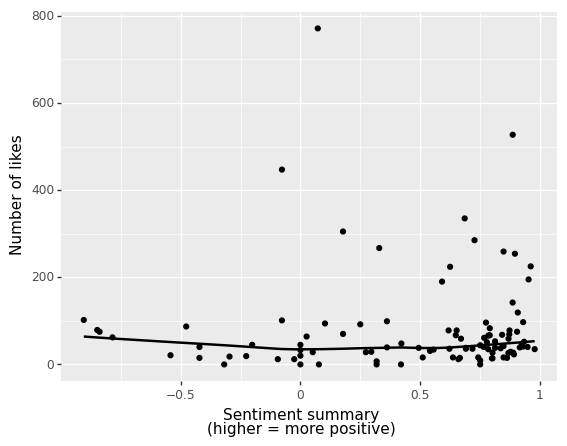

<ggplot: (8772779413992)>

In [19]:
## no clear relationship
(ggplot(senator_tweets_df, aes(x = 'compound_sent', y = 'public_metrics')) +
geom_point() +
xlab("Sentiment summary\n(higher = more positive)") +
ylab("Number of likes") +
geom_smooth())
